In [1]:
import cv2
import numpy as np

In [5]:
def timeVideo(in_add, out_add):
    
    cap = cv2.VideoCapture(in_add)
    ret, frame = cap.read()
    count = 1
    
    while(cap.isOpened()):
        if ret:
            cv2.imwrite(out_add + "/frame{}.png".format(count), frame)
            count += 1

        else:
            break
        ret, frame = cap.read()

    cap.release()
    cv2.destroyAllWindows()
    print(count)

In [6]:
timeVideo("./data/test.mp4", "./data/frames_test")

10799


In [3]:
from dataloader import *
from torchvision import transforms
from torchvision.models import *

In [4]:
class Resnet50(object):

    def __init__(self):
        self.resnet50 = wide_resnet50_2(pretrained=True).eval()
        self.resnet50 = self.resnet50.to("cuda:0")
    def __call__(self, sample):
        sample = sample.to("cuda:0")
        with torch.no_grad():
            out = self.resnet50(sample.unsqueeze(0))
            return out.squeeze()

In [5]:
preprocess_in = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((240, 240)),
    Resnet50()
])

In [11]:
tr_loader = commaai("./data", preprocess_in)
tra, val = random_split(tr_loader, [int(len(tr_loader) * 0.8), int(len(tr_loader) * 0.2)])
train_loader = DataLoader(dataset = tra, batch_size = 32, shuffle = True)
val_loader = DataLoader(dataset = val, batch_size = 32, shuffle = True)

In [7]:
preprocess_in.

TypeError: 'Compose' object does not support indexing

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt



def dense_optical_flow(method, video_path, params=[], to_gray=False):
    # read the video
    cap = cv2.VideoCapture(video_path)
    # Read the first frame
    ret, old_frame = cap.read()

    # crate HSV & make Value a constant
    hsv = np.zeros_like(old_frame)
    hsv[..., 1] = 255

    # Preprocessing for exact method
    if to_gray:
        old_frame = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

    while True:
        # Read the next frame
        ret, new_frame = cap.read()
        frame_copy = new_frame
        if not ret:
            break
        # Preprocessing for exact method
        if to_gray:
            new_frame = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)
        # Calculate Optical Flow
        flow = method(old_frame, new_frame, None, *params)

        # Encoding: convert the algorithm's output into Polar coordinates
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        # Use Hue and Saturation to encode the Optical Flow
        hsv[..., 0] = ang * 180 / np.pi / 2
        hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
        # Convert HSV image into BGR for demo
        bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        #cv2.imshow("frame", frame_copy)
        img2 = frame_copy[:,:,::-1]
        plt.imshow(img2)
        #cv2.imshow("optical flow", bgr)
        img2 = bgr[:,:,::-1]
        plt.imshow(img2)
        k = cv2.waitKey(25) & 0xFF
        if k == 27:
            break
        old_frame = new_frame

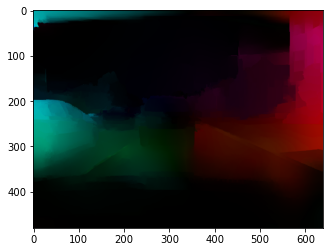

In [6]:
method = cv2.optflow.calcOpticalFlowSparseToDense
dense_optical_flow(method, "./data/train.mp4", to_gray=True)

In [ ]:
def lucas_kanade_method(video_path):
    cap = cv2.VideoCapture(video_path)
    # params for ShiTomasi corner detection
    feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
    # Parameters for lucas kanade optical flow
    lk_params = dict(
        winSize=(15, 15),
        maxLevel=2,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
    )
    # Create some random colors
    color = np.random.randint(0, 255, (100, 3))
    # Take first frame and find corners in it
    ret, old_frame = cap.read()
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
    # Create a mask image for drawing purposes
    mask = np.zeros_like(old_frame)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(
            old_gray, frame_gray, p0, None, **lk_params
        )
        # Select good points
        good_new = p1[st == 1]
        good_old = p0[st == 1]
        # draw the tracks
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv2.line(mask, (a, b), (c, d), color[i].tolist(), 2)
            frame = cv2.circle(frame, (a, b), 5, color[i].tolist(), -1)
        img = cv2.add(frame, mask)
        cv2.imshow("frame", img)
        k = cv2.waitKey(25) & 0xFF
        if k == 27:
            break
        if k == ord("c"):
            mask = np.zeros_like(old_frame)
        # Now update the previous frame and previous points
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)